<a href="https://colab.research.google.com/github/christianbv/AgeNet/blob/main/Notebooks/1_Validate_IMDB_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Imports 

In [ ]:
import os
from os import walk 

from os import listdir
from os.path import isfile, join
from IPython.display import display
from PIL import Image, ImageDraw
import numpy as np
import glob
import shutil
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
tf.get_logger().setLevel('ERROR')

In [ ]:
#@markdown <b>Run me to import underscore module</b><br/>   {display-mode: "form"}
#@markdown <small>Method signatures:</small><br/> 
#@markdown <small><small>&nbsp; &nbsp; &nbsp; __(source_path, target_path, copy=True, auth_on_upload=True)</small></small><br/>
#@markdown <small><small>&nbsp; &nbsp; &nbsp; _set_gh_token(token)</small></small><br/>
#@markdown <small><small>&nbsp; &nbsp; &nbsp; _from_gh(user_name, repo_name, release_name) &nbsp; &nbsp; &nbsp; <b>Returns:</B> dictionary of arrays { 'array_name' : np.ndarray }</small></small><br/>
#@markdown <small><small>&nbsp; &nbsp; &nbsp; _to_gh(user_name, repo_name, release_name, split_size=600, **arr_kwargs)</small></small><br/>


!pip install -q githubrelease
import numpy as np
import os, glob, re, time
import github_release

compressed_dirs = set()


def _compress(source_path, target_path, target_dir=None):
    if target_dir:
        !mkdir -p {target_dir}
    if target_path.endswith('.tar.gz'):
        !tar -czf {target_path} -C {source_path} .
    elif target_path.endswith('.tar'):
        !tar -cf {target_path} -C {source_path} .
    elif target_path.endswith('.zip'):
        !(cd {source_path} && zip -q -r {target_path} .)


def _extract(source_path, target_path):
    !mkdir -p {target_path}
    if source_path.endswith('.tar.gz'):
        !tar -xzf {source_path} -C {target_path}
    elif source_path.endswith('.tar'):
        !tar -xf {source_path} -C {target_path}
    elif source_path.endswith('.zip'):
        !unzip -qq {source_path} -d {target_path}


def __(source_path, target_path, copy=True, auth_on_upload=True):
    """
    Use cases:
        Movement:
            - GCS -> GCS
            - GCS -> LOCAL
            - LOCAL -> GCS
            - LOCAL -> LOCAL
            
        Compression (e.g. from dir to .tar.gz):
            - GCS -> GCS
            - GCS -> LOCAL
            - LOCAL -> GCS
            - LOCAL -> LOCAL
            
        Extraction (e.g. from .zip to dir):
            - GCS -> GCS
            - GCS -> LOCAL
            - LOCAL -> GCS
            - LOCAL -> LOCAL
            
        Extraction & compression (e.g. from .zip to .tar.gz):
            - GCS -> GCS
            - GCS -> LOCAL
            - LOCAL -> GCS
            - LOCAL -> LOCAL
    """
    COMPRESSION_FORMATS = ('zip', 'tar', 'tar.gz')
    TEMP_DIR = "/tmp_"
    LOG_TEMPLATE = "{}    from    {}    to    {}"

    # Source
    if source_path.endswith("/"):
        source_path = source_path[:-1]
    source_dir, _, source_name = source_path.rpartition('/')
    source_isgcs = source_path.startswith("gs://")
    source_islocal = not source_isgcs
    if source_islocal:
        source_path = os.path.abspath(source_path)
    source_isprefix, source_isfile, source_ext = source_name.partition('.')
    source_isdir = not source_isfile
    source_iscompression = source_ext in COMPRESSION_FORMATS

    # Target
    target_dir, _, target_name = target_path.rpartition('/')
    target_isgcs = target_path.startswith("gs://")
    target_islocal = not target_isgcs
    target_prefix, target_isfile, target_ext = target_name.partition('.')
    target_isdir = not target_isfile
    target_iscompression = target_ext in COMPRESSION_FORMATS

    # Flags
    MOVE_ONLY = source_ext == target_ext
    GCS_ONLY = source_isgcs and target_isgcs
    RENAME = source_isprefix != target_prefix
    COMPRESSION = source_isdir and target_iscompression
    EXTRACTION = source_iscompression and target_isdir
    EXTRACTION_COMPRESSION = source_iscompression and target_iscompression and source_ext != target_ext

    # Add forward slash if file is at root level
    source_dir = "/" if not source_dir else source_dir
    target_dir = "/" if not target_dir else target_dir

    # Authenticate if writing to GCS
    if target_isgcs and auth_on_upload:
        from google.colab import auth
        auth.authenticate_user()

    # Assert that subdirectories exist if target is local
    if target_islocal:
        !mkdir -p {target_dir}

    # Movement commands
    if MOVE_ONLY:
        # GCS -> GCS
        if source_isgcs and target_isgcs:
            action = "COPYING" if copy else "MOVING"
            print(LOG_TEMPLATE.format(f"{action} (1/1)", source_path, target_path))
            if copy:
                !gsutil -m -q cp -r {source_path} {target_path}
            else:
                !gsutil -m -q mv {source_path} {target_path}
        
        # LOCAL -> LOCAL
        elif source_islocal and target_islocal:
            action = "COPYING" if copy else "MOVING"
            print(LOG_TEMPLATE.format(f"{action} (1/1)", source_path, target_path))
            if copy:
                !cp -r {source_path} {target_path}
            else:
                !mv {source_path} {target_path}
        
        # GCS -> LOCAL
        elif source_isgcs and target_islocal:
            if source_isdir:
                print(LOG_TEMPLATE.format("DOWNLOADING DIR (1/1)", source_path, target_dir))
                !gsutil -m -q cp -r {source_path} {target_dir}
                if RENAME:
                    print(LOG_TEMPLATE.format("\tRENAMING DIR", source_isprefix, target_prefix))
                    !mv {target_dir}/{source_isprefix} {target_dir}/{target_prefix}
            else:
                print(LOG_TEMPLATE.format("DOWNLOADING FILE (1/1)", source_path, target_path))
                !gsutil -m -q cp {source_path} {target_path}
        
        # LOCAL -> GCS
        if source_islocal and target_isgcs:
            if source_isdir:
                print(LOG_TEMPLATE.format("UPLOADING DIR (1/1)", source_path, target_path))
                !gsutil -m -q cp -r {source_path} {target_path}
            else:
                print(LOG_TEMPLATE.format("UPLOADING FILE (1/1)", source_path, target_path))
                !gsutil -m -q cp {source_path} {target_path}
        return


    # Create directory for intermediate storage if required
    if source_isgcs or target_isgcs or EXTRACTION_COMPRESSION:
        !mkdir -p {TEMP_DIR}
    

    # For remaining operations, download GCS source to temp and treat as local
    if source_isgcs:
        if source_isdir:
            print(LOG_TEMPLATE.format("\tDOWNLOADING DIR", source_path, TEMP_DIR))
            !gsutil -m -q cp -r {source_path} {TEMP_DIR}
        else:
            print(LOG_TEMPLATE.format("\tDOWNLOADING FILE", source_path, f"{TEMP_DIR}/{source_name}"))
            !gsutil -m -q cp {source_path} {TEMP_DIR}/{source_name}
        source_path = f"{TEMP_DIR}/{source_name}"
        source_dir = TEMP_DIR

    # Compression
    if COMPRESSION:
        if target_islocal:
            print(LOG_TEMPLATE.format("COMPRESSING (1/1)", source_path, target_path))
            _compress(source_path, target_path, target_dir=target_dir)
        else:
            print(LOG_TEMPLATE.format("COMPRESSING (1/2)", source_path, f"{TEMP_DIR}/{target_name}"))
            _compress(source_path, f"{TEMP_DIR}/{target_name}")
            print(LOG_TEMPLATE.format("UPLOADING FILE (2/2)", f"{TEMP_DIR}/{target_name}", target_path))
            !gsutil -m -q cp {TEMP_DIR}/{target_name} {target_path}

    # Extraction
    elif EXTRACTION:
        if target_islocal:
            print(LOG_TEMPLATE.format("EXTRACTING (1/1)", source_path, target_path))
            _extract(source_path, target_path)
        else:
            print(LOG_TEMPLATE.format("EXTRACTING (1/2)", source_path, f"{TEMP_DIR}/{target_name}"))
            _extract(source_path, f"{TEMP_DIR}/{target_name}")
            print(LOG_TEMPLATE.format("UPLOADING DIR (2/2)", f"{TEMP_DIR}/{target_name}", target_path))
            !gsutil -m -q cp -r {TEMP_DIR}/{target_name} {target_path}

    # Extraction & compression
    elif EXTRACTION_COMPRESSION:
        if target_islocal:
            print(LOG_TEMPLATE.format("EXTRACTING (1/2)", source_path, f"{TEMP_DIR}/{target_prefix}"))
            _extract(source_path, f"{TEMP_DIR}/{target_prefix}")
            print(LOG_TEMPLATE.format("COMPRESSING (2/2)", f"{TEMP_DIR}/{target_prefix}", target_path))
            _compress(f"{TEMP_DIR}/{target_prefix}", target_path, target_dir=target_dir)
        else:
            print(LOG_TEMPLATE.format("EXTRACTING (1/3)", source_path, f"{TEMP_DIR}/{target_prefix}"))
            _extract(source_path, f"{TEMP_DIR}/{target_prefix}")
            print(LOG_TEMPLATE.format("COMPRESSING (2/3)", f"{TEMP_DIR}/{target_prefix}", f"{TEMP_DIR}/{target_name}"))
            _compress(f"{TEMP_DIR}/{target_prefix}", f"{TEMP_DIR}/{target_name}")
            print(LOG_TEMPLATE.format("UPLOADING FILE (3/3)", f"{TEMP_DIR}/{target_name}", target_path))
            !gsutil -m -q cp {TEMP_DIR}/{target_name} {target_path}
    
    # Cleanup intermediate storage
    !rm -rf {TEMP_DIR}


def _set_gh_token(token):
    os.environ["GITHUB_TOKEN"] = token


def _export_array(array, release_name, prefix="", splits=3):
    dir_path = f"/tmp_/{release_name}"
    !mkdir -p {dir_path}
    n_digits = len(str(splits - 1))
    subarrays = np.array_split(array, splits)
    for i, subarray in enumerate(subarrays):
        filename = f"{prefix}__{str(i).zfill(n_digits)}.npy"
        np.save(f"{dir_path}/{filename}", subarray)


def _concat_arrays(paths):
    return np.concatenate([np.load(path, allow_pickle=True) for path in sorted(paths)])


def _to_gh(user_name, repo_name, release_name, split_size=600, **arr_kwargs):
    # Assert that GitHub Auth token is set
    if "GITHUB_TOKEN" not in os.environ:
        print("GitHub authentication token is not set.")
        print("Set token using the '_set_gh_token(token_string)' method.")
        print("Minimal required auth scope is 'repo/public_repo' for public repositories.")
        print("URL: https://github.com/settings/tokens/new")
        return

    # Split arrays
    for prefix, array in arr_kwargs.items():
        splits = int((array.nbytes/1_000_000) // split_size) + 1
        _export_array(array, release_name, prefix=prefix, splits=splits)

    # Upload arrays
    github_release.gh_release_create(
        f"{user_name}/{repo_name}", 
        release_name, 
        publish=True, 
        name=release_name, 
        asset_pattern=f"/tmp_/{release_name}/*"
    )
    !rm -rf /tmp_/*


def _from_gh(user_name, repo_name, release_name):
    # Download release to temporary directory
    print("Downloading dataset in parallell ... ", end='\t')
    t0 = time.perf_counter()
    assets = github_release.get_assets(f"{user_name}/{repo_name}", tag_name=release_name)
    download_urls = [asset['browser_download_url'] for asset in assets]
    urls_str = " ".join(download_urls)
    !echo {urls_str} | xargs -n 1 -P 8 wget -q -P /tmp_/{release_name}_dl/
    t1 = time.perf_counter()
    print(f"done! ({t1 - t0:.3f} seconds)")

    # Load data into numpy arrays
    paths = glob.glob(f"/tmp_/{release_name}_dl/*.npy")
    groups = {}
    for path in paths:
        match = re.match(r".*/(.*)__[0-9]*\.npy", path)
        if match:
            prefix = match.group(1)
            groups[prefix] = groups.get(prefix, []) + [path]
    arrays_dict = {name: _concat_arrays(paths) for name, paths in groups.items()}
    !rm -rf /tmp_/*
    return arrays_dict
    

def _log_to_gh(user, repo, tag, log_dir="/tmp/logs"):
    # Create temporary directory for compressed logs
    !mkdir -p /tmp/compressed_logs
    
    # Compress all directories in log dir
    for dirname in os.listdir(log_dir):
        # Skip files
        if "." in dirname or dirname in compressed_dirs:
            continue

        # Compress
        __(f"{log_dir}/{dirname}", f"/tmp/compressed_logs/{dirname}.tar.gz")
        compressed_dirs.add(dirname)

    # Upload compressed logs to GitHub
    github_release.gh_asset_upload(f"{user}/{repo}", tag, f"/tmp/compressed_logs/*.tar.gz")

    # Cleanup compressed logs
    !rm -rf /tmp/compressed_logs/*

# 1. Download a chosen preliminary model to validate the IMDB data

In [ ]:
__("gs://ntnu-ml-bucket/IMDB/batches/batch-2-num_pic-5392-id-7413.zip","/content/IMDB_images",auth_on_upload= False)
__( "gs://https://ntnu-ml-bucket/models/model_adam_v2_14_11.zip","/content/model", auth_on_upload=False) # Specify the model to evaluate the IMDB data
model = tf.keras.models.load_model("/content/model")

	DOWNLOADING FILE    from    gs://ntnu-ml-bucket/IMDB/batches/batch-2-num_pic-5392-id-7413.zip    to    /tmp_/batch-2-num_pic-5392-id-7413.zip
EXTRACTING (1/1)    from    /tmp_/batch-2-num_pic-5392-id-7413.zip    to    /content/IMDB_images
	DOWNLOADING FILE    from    gs://ntnu-ml-bucket/models/model_1_09_11.zip    to    /tmp_/model_1_09_11.zip
EXTRACTING (1/1)    from    /tmp_/model_1_09_11.zip    to    /content/model


In [ ]:
## Download the raw IMDB dataset
__("gs://ntnu-ml-bucket/IMDB/batches/batch-4-num_pic-46127-id-8307.zip","/content/IMDB_images",auth_on_upload= False)

	DOWNLOADING FILE    from    gs://ntnu-ml-bucket/IMDB/batches/batch-4-num_pic-46127-id-8307.zip    to    /tmp_/batch-4-num_pic-46127-id-8307.zip
EXTRACTING (1/1)    from    /tmp_/batch-4-num_pic-46127-id-8307.zip    to    /content/IMDB_images


# 2. Validate the IMDB images by checking if they pass a threshold 

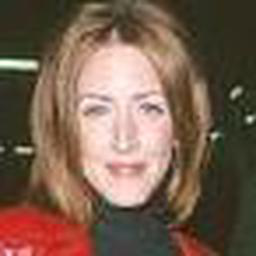

saved 500


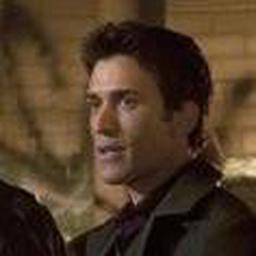

saved 1000


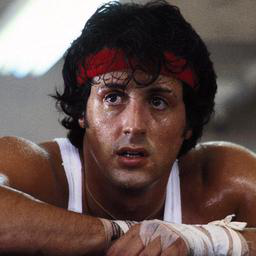

saved 1500


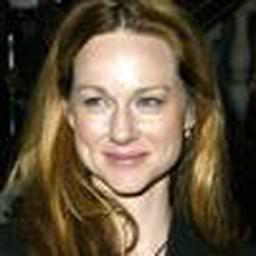

saved 2000


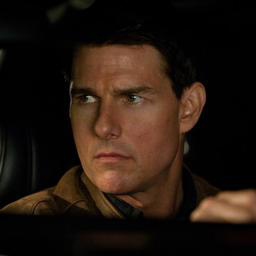

saved 2500


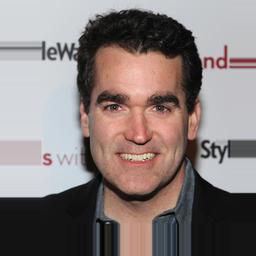

saved 3000


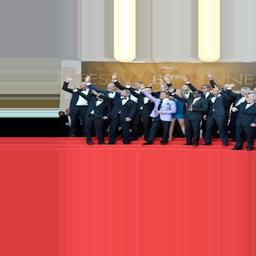

saved 3500


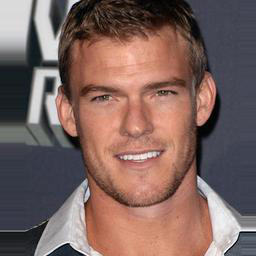

saved 4000


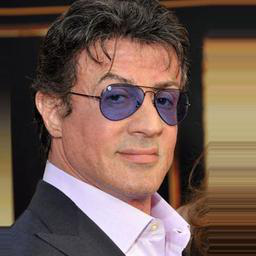

saved 4500


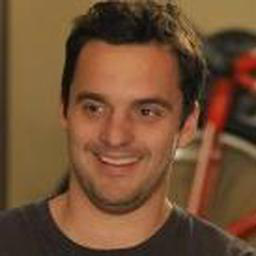

saved 5000


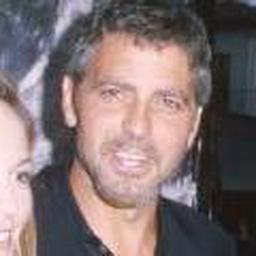

saved 5500


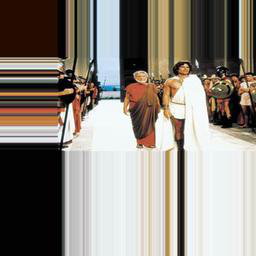

saved 6000


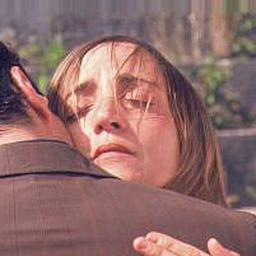

saved 6500


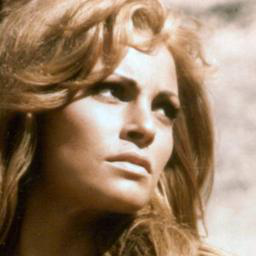

saved 7000


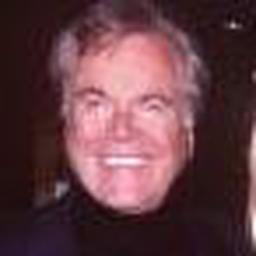

saved 7500


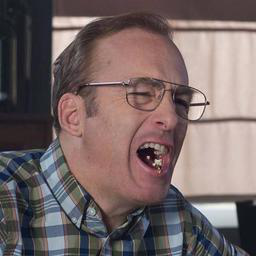

saved 8000


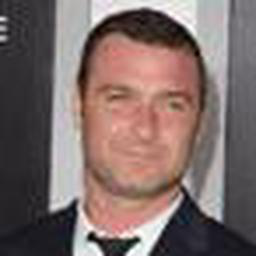

saved 8500


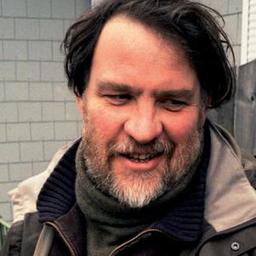

saved 9000


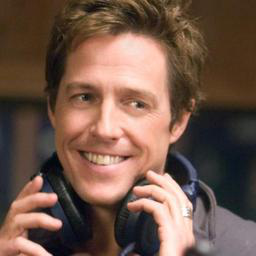

saved 9500


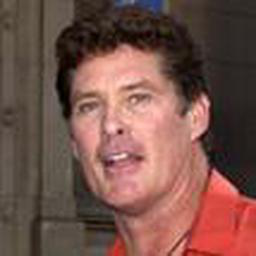

saved 10000


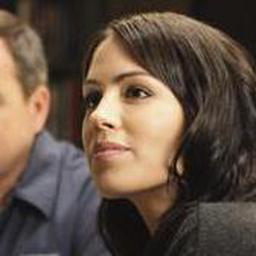

saved 10500


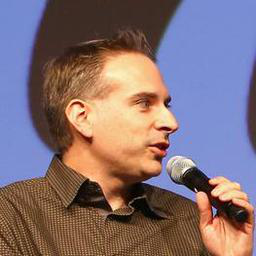

saved 11000


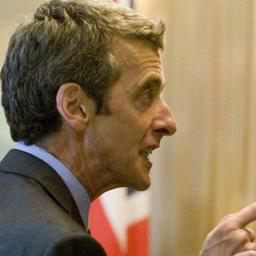

saved 11500


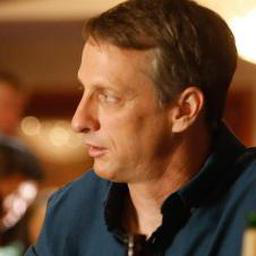

saved 12000


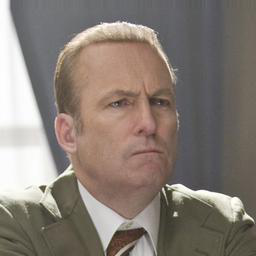

saved 12500


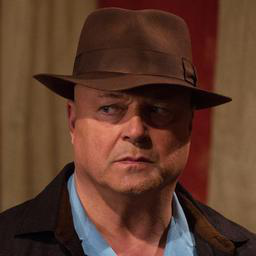

saved 13000


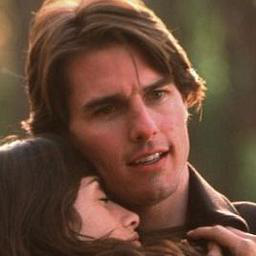

saved 13500


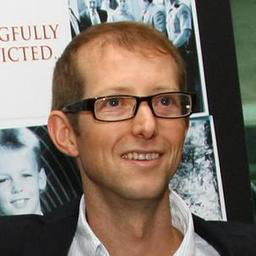

saved 14000


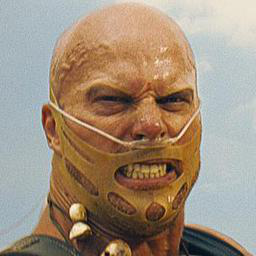

saved 14500


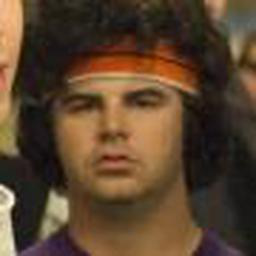

saved 15000


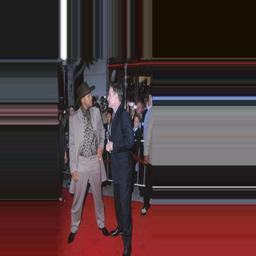

saved 15500


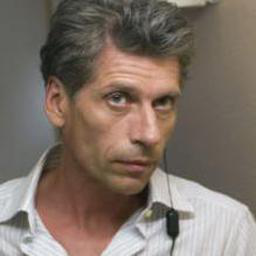

saved 16000


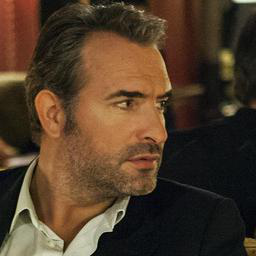

saved 16500


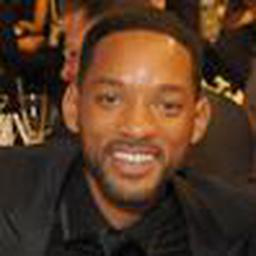

saved 17000


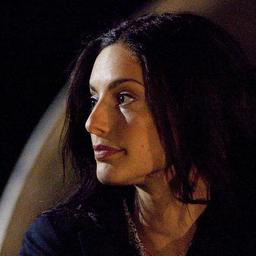

saved 17500


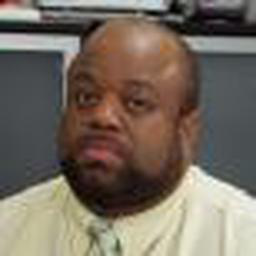

saved 18000
Processed 46127 pictures
  fonud 2457 black and white pictures
  and 18197 unclear images below 0.42 threshold 
COMPRESSING (1/2)    from    /content/saved_images    to    /tmp_/quality_4.zip
UPLOADING FILE (2/2)    from    /tmp_/quality_4.zip    to    gs://ntnu-ml-bucket/IMDB/quality_4.zip


In [ ]:
count = 0 
satisfied = 400000
num_black_white = 0
processed = 0
thresh = 0.42
BUCKETS =[0,3,7,13,18,23,27,34,45,60,200]
class_labels = ['0-2', '3-6', '7-12', '13-17', '18-22', '23-26', '27-33', '34-44', '45-59', '60-199']

def get_bin_age(buckets, age):
  for i in range(len(buckets)):
    if age < buckets[i]:
      return f"{buckets[i-1]}-{buckets[i]-1}"
  return "undf"


for (dirpath, dirnames, filenames) in walk ("/content/IMDB_images"):
      for f in filenames:
        if not f.endswith(".jpg"):
          continue

        processed += 1
        img = Image.open(dirpath +"/" + f)
        age = int(f.split('_')[0])
        bin_label = get_bin_age(BUCKETS,age)
        if(bin_label == '200--1'):
          continue
        correct = class_labels.index(bin_label)

        #img = preprocess_image(dirpath +"/" + f)
        img_array = keras.preprocessing.image.img_to_array(img)
        if(img_array.size < 150000): 
          num_black_white += 1
          continue
        img_array = tf.expand_dims(img_array, 0) # Create a batch

        predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0])
        precision = score[correct] +  0.5*score[max(0,correct -1)] +  0.5*score[min(len(class_labels)-1,correct+1)]
        if(precision < thresh):
          continue
          
        if os.path.isfile("/content/saved_images/"+f):
          continue
        

        shutil.move(dirpath + "/" + f, "/content/saved_images/" + f)
        #__(dirpath +"/" + f,"/content/saved_images/"+f)
        count += 1
        if(count % 500  == 0):
            display(img)
            print(f"saved {count}")
        if (count >= satisfied):break
      if (count >= satisfied): break


print(f"Processed {processed} pictures")
print(f"  fonud {num_black_white} black and white pictures")
print(f"  and {count} unclear images below {thresh} threshold ")
__("/content/saved_images","gs://ntnu-ml-bucket/IMDB/quality_4.zip", auth_on_upload=False)

# 3. Save the valid images back to Google Cloud Platform

In [ ]:
## Save the preprocessed IMDB pictures back to Google Cloud Platform
__("/content/saved_images","gs://ntnu-ml-bucket/IMDB/quality_1.zip", auth_on_upload=False)

COMPRESSING (1/2)    from    /content/saved_images    to    /tmp_/quality_1.zip
UPLOADING FILE (2/2)    from    /tmp_/quality_1.zip    to    gs://ntnu-ml-bucket/IMDB/quality_1.zip
